In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from pandas.plotting import parallel_coordinates

In [2]:
complete_data = pd.read_csv("EnergiaData.csv")
grouped_data = complete_data.groupby("AnonymisedMPRN").mean().iloc[:, 1:]
data_by_MPRN = grouped_data.copy()
time_interval_columns = grouped_data.columns

C:\Users\daniy\AppData\Local\Temp\ipykernel_9136\3648659894.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = complete_data.groupby("AnonymisedMPRN").mean().iloc[:, 1:]


In [3]:
def capOutliers(data, cap_threshold):
    # Apply capping
    return data.apply(lambda x: np.where(x > x.mean() + cap_threshold * x.std(), 
                                                                   x.mean() + cap_threshold * x.std(),
                                                                   np.where(x < x.mean() - cap_threshold * x.std(), 
                                                                            x.mean() - cap_threshold * x.std(), x)))

In [4]:
data_capped = capOutliers(data_by_MPRN[time_interval_columns], 3)

In [5]:
def scaleData(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

In [10]:
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

In [46]:
class OptimalK:
    def __init__(self, K_range, data):
        """
        Initializes the OptimalK class with the provided K range and data.

        Parameters:
        - K_range (iterable): Range of values for the number of clusters (K) to evaluate.
        - data (array-like): The data to cluster, typically a 2D array or DataFrame.
        """
        self.K_range = K_range
        self.data = data
        self.labels = []
        self.inertia = []
        self.silhouette_scores = []
        self.davies_bouldin_scores = []
        self.calinski_harabasz_scores = []
        self.bic_scores = []
        self.model = None

    def algorithm(self, cluster_algo, **kwargs):
        """
        Applies the given clustering algorithm for each K in the specified range and computes various clustering metrics.

        Parameters:
        - cluster_algo (class): A clustering algorithm class (e.g., KMeans).
        - **kwargs: Additional keyword arguments to pass to the clustering algorithm.
        """
        for k in self.K_range:
            self.model = cluster_algo(k, **kwargs)
            labels = self.model.fit_predict(self.data)
            self.labels.append(labels)
            
            # Store inertia if available
            if hasattr(self.model, 'inertia_'):
                self.inertia.append(self.model.inertia_)
                
            if hasattr(self.model, 'bic'):
                self.bic_scores.append(self.model.bic(self.data))

    def plotKScores(self, score, y_label):
        """
        Plots the clustering scores for different values of K.

        Parameters:
        - score (list): The list of scores to plot.
        - y_label (str): The label for the y-axis.
        - title (str): The title of the plot.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(self.K_range, score, 'bo-')
        plt.xlabel('Number of clusters (K)')
        plt.ylabel(y_label)
        plt.title(f'{y_label} vs. Number of Clusters')
        plt.grid(True)
        plt.show()

    def inertiaScore(self):
        """
        Plots the inertia values over the range of K.
        """
        self.plotKScores(self.inertia, 'Inertia')

    def silhouetteScores(self):
        """
        Computes and plots the silhouette scores for different values of K.
        """
        for labels in self.labels:
            score = silhouette_score(self.data, labels)
            self.silhouette_scores.append(score)
        
        self.plotKScores(self.silhouette_scores, 'Silhouette Score')

    def daviesBouldinScores(self):
        """
        Computes and plots the Davies-Bouldin scores for different values of K.
        """
        for labels in self.labels:
            score = davies_bouldin_score(self.data, labels)
            self.davies_bouldin_scores.append(score)
        
        self.plotKScores(self.davies_bouldin_scores, 'Davies-Bouldin Index')

    def calinskiHarabaszScores(self):
        """
        Computes and plots the Calinski-Harabasz scores for different values of K.
        """
        for labels in self.labels:
            score = calinski_harabasz_score(self.data, labels)
            self.calinski_harabasz_scores.append(score)
        
        self.plotKScores(self.calinski_harabasz_scores, 'Calinski-Harabasz Index')
        
    def bicScore(self):
        """
        Plots the inertia values over the range of K.
        """
        self.plotKScores(self.bic_scores, 'Bayesian Information Criterion')


In [37]:
k_component = OptimalK(range(2, 30), scaleData(data_capped))
k_component.algorithm(KMeans, random_state=42, n_init=10)

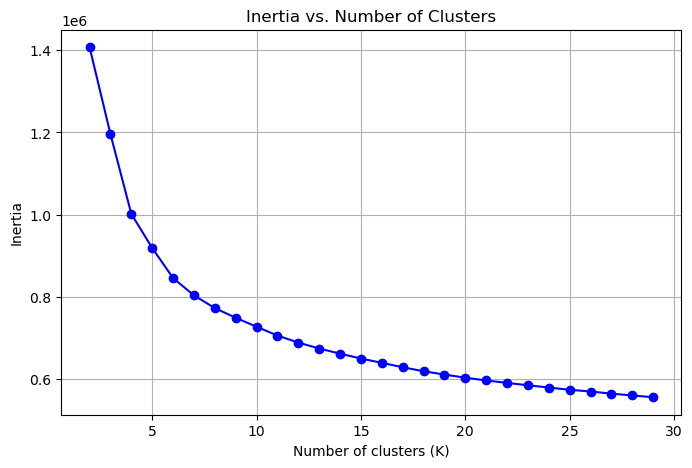

In [38]:
k_component.inertiaScore()

In [39]:
k_component.silhouetteScores()

MemoryError: Unable to allocate 1.00 GiB for an array with shape (3071, 43699) and data type float64

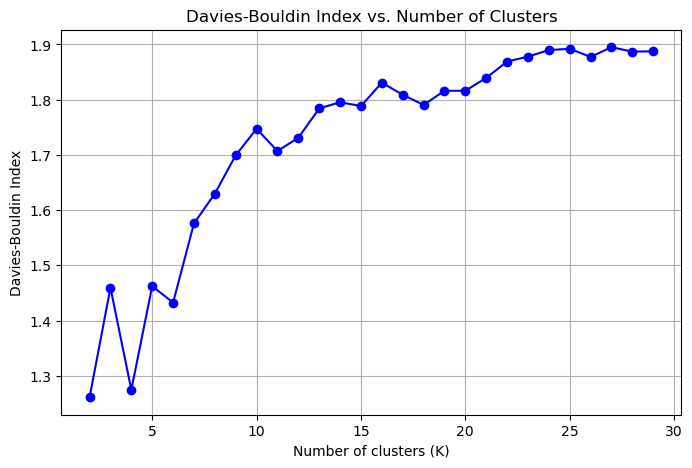

In [40]:
k_component.daviesBouldinScores()

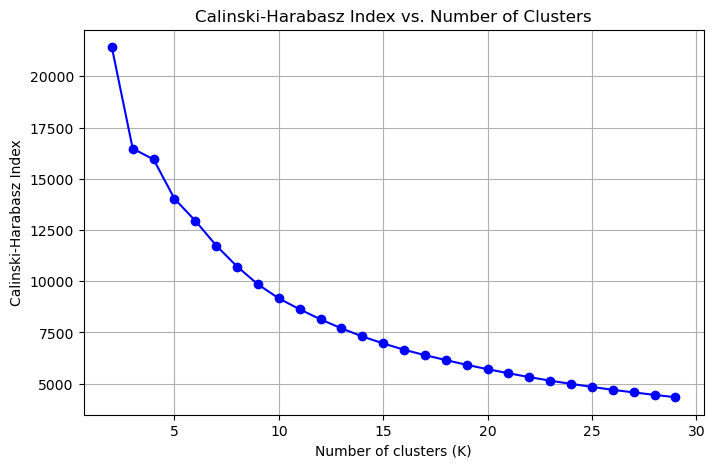

In [41]:
k_component.calinskiHarabaszScores()

In [47]:
k_component_GMM = OptimalK(range(2, 30), scaleData(data_capped))
k_component_GMM.algorithm(GaussianMixture, random_state=42, n_init=10)

MemoryError: Unable to allocate 16.0 MiB for an array with shape (43699, 48) and data type float64

In [ ]:
k_component_GMM.bicScore()

### Thus, the optimal number of clusters would be in the range of 5 to 8.